In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import clear_output
import os

%matplotlib inline



# Train tabular Q-learning agent in a gridworld environment

In [8]:
# Q LEARNING parameters
ALPHA = .5 # update weight
EPSILON=0.3 # epsilon - greedy exploration
EPISODES = 10000 # num training episodes
NPIXELX,NPIXELY = 10,10 # size of environment

figdir = "G:\\My Drive\\CS230Project\\milestone2_figs"

In [9]:
# define agent class
class hand():
    '''
    agent control class
    '''
    def __init__(self, npixely, npixelx):
        
        self.hand_pos = [0,0] # hand position
        self.targ_pos = [None,None] # target position
        self.npixelx = npixelx # size of environment in x direction
        self.npixely = npixely # size of environment in y direction
        
        self._init_qfunc() # initialize Q function
        
        self.actions = [[-1,0], # action space x and y moves 
                       [1,0],
                       [0,-1],
                       [0,1],
                       [-1,-1],
                       [1,-1],
                       [-1,1],
                       [1,1]]
        
    def _init_qfunc(self):
        '''
        initialize Q function randomly
        '''
        self.Q = {}
        for hposy in range(self.npixelx): # for each state
            for hposx in range(self.npixely):
                self.Q[(hposy,hposx)]= np.random.randn(8) # init Q
                
                        
    def init_hand_pos(self,y,x):
        '''
        place hand
        ---------
        Parameters
        ---------
        y: int (0,npixely-1)
            initial y position
        x: int (0,npixelx-1)
            initial x position
        '''
        self.hand_pos = [y,x]
    def update_hand_pos(self,dy,dx):
        '''
        move hand by [dy, dx] pixels
        ----------
        Parameters
        ----------
        dy : amount of pixels to move in y direction
        dx : amount of pixels to move in x direction
        '''
        self.hand_pos=[np.clip(self.hand_pos[0]+dy,0, self.npixely-1),np.clip(self.hand_pos[1]+dx,0,self.npixelx-1)]
        
    def init_targ_pos(self,y,x):
        '''
        place target
        '''
        self.targ_pos=[y,x]
                                
   
    def get_Q(self,hpos):
        '''
        return Q value for state
        '''
        return self.Q[tuple(hpos)]

    
    
                        



### Learn Q function with TD(0) learning and $\epsilon$ - greedy policy

In [22]:
rewards = []
counter = 0
COUNTERS = []

# init agent
h = hand(NPIXELY,NPIXELX)


for ep in range(EPISODES): # for each episode

    # init state
    h.init_hand_pos(np.random.randint(NPIXELY),np.random.randint(NPIXELX))
    h.init_targ_pos(8,5) # keep target in same location

    
    if ep%1000 ==0:
        print('episode',ep,'steps to reward',counter)

    counter = 0 # initialize step to reward counter
    while h.hand_pos != h.targ_pos: # until target is reached

        # choose action using Q[state] epsilon greedy
        if np.random.rand()<EPSILON:
            a = np.random.randint(8)
        else:
            a= np.argmax(h.get_Q(h.hand_pos))

    
        # old hand position
        h_old = h.hand_pos[:]
        # action
        action = h.actions[a]
        # new state
        h.update_hand_pos(action[0],action[1])
        
        # if not at target
        if h.hand_pos != h.targ_pos:
            reward = -1
        else:
            reward = 0
        rewards.append(reward) # append rewards
        # TD (0) update
        h.Q[tuple(h_old)][a] += ALPHA*(reward + np.amax(h.get_Q(h.hand_pos)) - h.get_Q(h_old)[a])

        counter+=1
    COUNTERS.append(counter)

    

episode 0 steps to reward 0
episode 1000 steps to reward 6
episode 2000 steps to reward 1
episode 3000 steps to reward 4
episode 4000 steps to reward 5
episode 5000 steps to reward 1
episode 6000 steps to reward 3
episode 7000 steps to reward 5
episode 8000 steps to reward 7
episode 9000 steps to reward 2


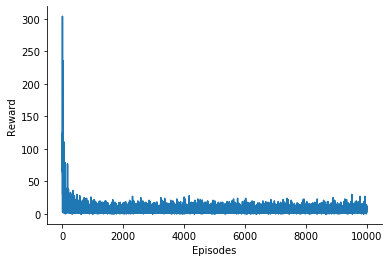

In [23]:
f,ax = plt.subplots()
ax.plot(COUNTERS[:])
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.savefig(os.path.join(figdir,"TabularQ_RewardsPerEpisode.pdf"),format='pdf')
f.savefig(os.path.join(figdir,"TabularQ_RewardsPerEpisode.png"),format='png')

## Examine performance on example episodes

In [24]:
# Generate some example agent trajectories
hand_pos = []
for it in range(20): # for each episode
    hand_pos.append([]) 
    h.init_hand_pos(np.random.randint(NPIXELY),np.random.randint(NPIXELX)) # place agent in random location
    hand_pos[-1].append([*h.hand_pos]) # save hand position

    while h.hand_pos != h.targ_pos: # until target is reached
        # choose action using Q[state]  - turn off epsilon greedy 
        a = np.argmax(h.get_Q(h.hand_pos))
        # update hand position
        h.update_hand_pos(*h.actions[a])
        counter+=1
        hand_pos[-1].append([*h.hand_pos])

odict_keys(['left', 'right', 'bottom', 'top'])


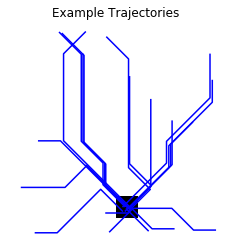

In [25]:
f,ax = plt.subplots()
im = np.zeros((NPIXELY,NPIXELX))
im[h.targ_pos[0],h.targ_pos[1]] = 1
ax.imshow(im,cmap='Greys',zorder=-1)

for it in range(len(hand_pos)):
    
    _hpos = np.array(hand_pos[it])
    _hpos = _hpos+.1*np.random.randn(1,2)
    ax.plot(_hpos[:,1],_hpos[:,0],color='blue')
    
ax.set_xticks([])
ax.set_yticks([])
print(ax.spines.keys())
for k in ax.spines:
    ax.spines[k].set_visible(False)
ax.set_title("Example Trajectories")
f.savefig(os.path.join(figdir,"tabularQLearningTrajectories.pdf"),format='pdf')
f.savefig(os.path.join(figdir,"tabularQLearningTrajectories.pdf"),format='png')


## Add force perturbations

In [26]:


h_wind = hand(NPIXELY,NPIXELX) # new agent
rewards = []
counter = 0
COUNTERS = []


for ep in range(EPISODES*10):

    # init state
    h_wind.init_hand_pos(np.random.randint(NPIXELY),np.random.randint(NPIXELX))
    h_wind.init_targ_pos(8,5) # initialize target

    
    if ep%1000 ==0:
        print('episode',ep,'steps to target',counter)

    counter = 0
    while h_wind.hand_pos != h_wind.targ_pos:

        # choose action using Q[state] epsilon greedy
        if np.random.rand()<EPSILON:
            a = np.random.randint(8)
        else:
            a= np.argmax(h_wind.get_Q(h_wind.hand_pos))

    
       # old state
        h_old = h_wind.hand_pos[:]
        # action
        action = h_wind.actions[a][:]
        
        # add wind - (modifies state transition) 
        if (h_wind.hand_pos[0]>=2) and (h_wind.hand_pos[0]<=6):
            action[1]-=1
        
        # new state
        h_wind.update_hand_pos(action[0],action[1])
        
        # calculate rewards
        if h_wind.hand_pos != h_wind.targ_pos:
            reward = -1
        else:
            reward = 0
        rewards.append(reward)
        
        # TD(0) update
        h_wind.Q[tuple(h_old)][a] += ALPHA*(reward + np.amax(h_wind.get_Q(h_wind.hand_pos)) - h_wind.get_Q(h_old)[a])

        counter+=1
    COUNTERS.append(counter)

episode 0 steps to target 0
episode 1000 steps to target 5
episode 2000 steps to target 6
episode 3000 steps to target 1
episode 4000 steps to target 11
episode 5000 steps to target 3
episode 6000 steps to target 2
episode 7000 steps to target 2
episode 8000 steps to target 5
episode 9000 steps to target 10
episode 10000 steps to target 7
episode 11000 steps to target 9
episode 12000 steps to target 4
episode 13000 steps to target 16
episode 14000 steps to target 3
episode 15000 steps to target 3
episode 16000 steps to target 7
episode 17000 steps to target 9
episode 18000 steps to target 22
episode 19000 steps to target 1
episode 20000 steps to target 8
episode 21000 steps to target 10
episode 22000 steps to target 2
episode 23000 steps to target 3
episode 24000 steps to target 14
episode 25000 steps to target 4
episode 26000 steps to target 16
episode 27000 steps to target 1
episode 28000 steps to target 21
episode 29000 steps to target 5
episode 30000 steps to target 1
episode 31000

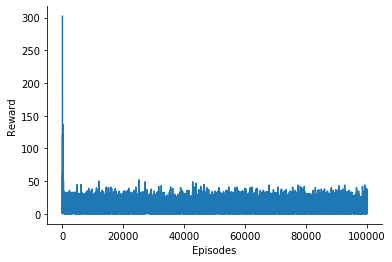

In [27]:
f,ax = plt.subplots()
ax.plot(COUNTERS[:])
ax.set_xlabel('Episodes')
ax.set_ylabel('Reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.savefig(os.path.join(figdir,"TabularQ_Curl_RewardsPerEpisode.pdf"),format='pdf')
f.savefig(os.path.join(figdir,"TabularQ_Curl_RewardsPerEpisode.png"),format='png')

In [28]:
# generate example trajectories
hand_pos = []
for it in range(20):
    hand_pos.append([]) 
    h_wind.init_hand_pos(np.random.randint(NPIXELY),np.random.randint(NPIXELX)) # hand position
    hand_pos[-1].append([*h_wind.hand_pos])

    while h_wind.hand_pos != h.targ_pos: # unitl target is reached
        # choose action using Q[state] 
        a = np.argmax(h_wind.get_Q(h_wind.hand_pos))
        h_wind.update_hand_pos(*h_wind.actions[a])
        counter+=1
        hand_pos[-1].append([*h_wind.hand_pos])

odict_keys(['left', 'right', 'bottom', 'top'])


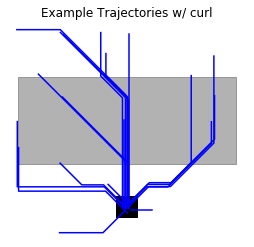

In [29]:
f,ax = plt.subplots()
im = np.zeros((NPIXELY,NPIXELX))
im[h_wind.targ_pos[0],h_wind.targ_pos[1]] = 1
ax.imshow(im,cmap='Greys')

ax.fill_between([0,10],[2,2],[6,6],color='black',alpha=.3)
for it in range(len(hand_pos)):
    
    _hpos = np.array(hand_pos[it])
    _hpos = _hpos+.1*np.random.randn(1,2)
    ax.plot(_hpos[:,1],_hpos[:,0],color='blue')

    
ax.set_xticks([])
ax.set_yticks([])
print(ax.spines.keys())
for k in ax.spines:
    ax.spines[k].set_visible(False)
ax.set_title("Example Trajectories w/ curl")
f.savefig(os.path.join(figdir,"tabularQLearningTrajectories_curl.pdf"),format='pdf')
f.savefig(os.path.join(figdir,"tabularQLearningTrajectories_curl.pdf"),format='png')